In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters

In [3]:
df = pd.read_csv(config.PROCESSED_DATA_PATH + 'ridewgps_labelled_culled.csv')
trips = clean_data.load_clean_ridewgps_trips()
df.head()

,id,labels
0,23209396,2
1,54372107,2
2,48496079,2
3,40433541,2
4,47936294,5


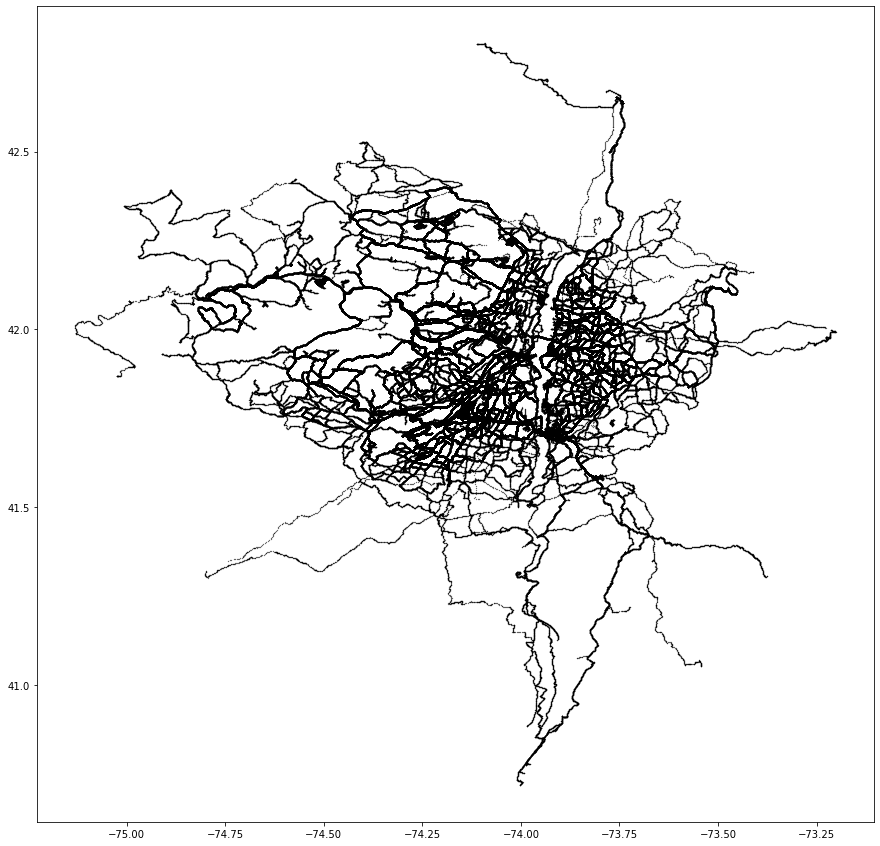

In [16]:
plt.figure(figsize=(15, 15))
plt.plot(trip_xy.x, trip_xy.y, 'k.', markersize=0.5)

In [12]:
res = pd.read_csv(config.RAW_TRIPS_PATH + '{}.csv'.format(df.id[0]))
trip_xy = res.iloc[[0]][['x', 'y']]
# plt.plot(trip_xy.x, trip_xy.y, 'k-')
for i, rid in enumerate(df.id.tolist()):
    if not i % 500: print(i)
    if not i % 10:
        res = pd.read_csv(config.RAW_TRIPS_PATH + '{}.csv'.format(rid))
        trip_xy = trip_xy.append(res.iloc[::10][['x', 'y']])
    
    

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500


In [208]:
df[df.labels == 5].id.sample().iloc[0]

11990224

In [209]:
# for rte_id in df.id.tolist():
#     get_data.ridewithgps_api_trip(rte_id)
rte_id = df[df.labels == 5].id.sample().iloc[0]
print(df[df.id == rte_id].labels.values)
print(trips[trips.id == rte_id][['id', 'distance', 'elevation_gain', 'avg_speed', 'prop_moving', 'duration']])
a = pd.read_csv(config.RAW_TRIPS_PATH + '{}.csv'.format(rte_id))
a.head()

[5]
            id  distance  elevation_gain  avg_speed  prop_moving  duration
3163  32254035  11.09635      538.848473  12.873662     0.584149  1.475556


,Unnamed: 0,T,d,e,h,s,t,x,y
0,0,13.0,2.90,-2.6,93.0,2.012,1551993413,-74.110786,41.776287
1,1,13.0,4.91,-2.6,92.0,2.012,1551993414,-74.110779,41.776306
2,2,13.0,25.79,-2.4,94.0,3.235,1551993420,-74.110718,41.776485
3,3,13.0,41.10,-2.0,97.0,2.869,1551993424,-74.110687,41.776623
4,4,12.0,56.88,-1.8,99.0,3.526,1551993428,-74.110649,41.776764


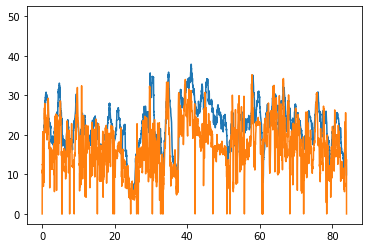

In [207]:
b = a[['x', 'y', 'e', 't']].copy()
b['x2'] = a.x[1:].tolist() + [a.iloc[-1].x]
b['y2'] = a.y[1:].tolist() + [a.iloc[-1].y]
b['d'] = mapping.dist_lat_lon(b.y, b.x, b.y2, b.x2)
b['cum_d'] = np.cumsum(b['d'])
b['t'] = (b['t'] - b['t'].min())
b['dt'] = b['t'].diff()
b['slope'] = mapping.metres_to_miles(b.e.diff()) / b.d * 100
b['slope'].fillna(0, inplace=True)
b.at[b['d'] == 0, 'slope'] = 0
b['slope'] = clean_data.moving_window_average(b['slope'], 50)
b['speed_rough'] = b.d / (b['t'].diff() / 60 / 60)
b['speed'] = clean_data.moving_window_average(b['speed_rough'], 50)
# plt.plot(np.cumsum(b.d), b.slope)
plt.plot(b.cum_d, b.speed)
plt.plot(mapping.metres_to_miles(a.d),mapping.mps_to_mph(a.s), 50)
# plt.xlim([1.5, 1.55])

In [191]:
# b[b.d < 0.002]['dt'].sum() / 60
# b[1.5 <= b.speed_rough].speed.mean()
b[b.speed_rough < 1.5].dt.sum() / 60 / 60

0.39916666666666667

In [205]:
clean_data.check_missing(a)

Unnamed: 0: 0 missing of 4940
T: 0 missing of 4940
d: 0 missing of 4940
e: 0 missing of 4940
h: 0 missing of 4940
t: 0 missing of 4940
s: 2 missing of 4940
x: 2 missing of 4940
y: 2 missing of 4940
c: 52 missing of 4940
lap: 4924 missing of 4940


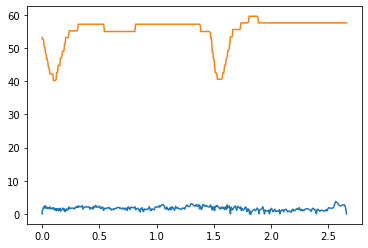

In [60]:
plt.plot(mapping.metres_to_miles(a['d']), a['s'])
plt.plot(mapping.metres_to_miles(a['d']), a['e'])
